In [16]:
import numpy as np
import os
import json
import pandas as pd
import csv
from datetime import date
import matplotlib.pylab as plt
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
import contractions

nltk.download('wordnet')
nltk.download('omw-1.4')

# preprocess
#  * pure text 2021-
#     * clean up text: stopwords, stemming, lowercase, strip urls/bad characters/HTML/etc, word-tokenization (incl. contractions), drop numbers
#     * text to vectors: BOW, also TFIDF, also word embeddings
#  * tabular 2008-21-
#     * EDA - plot distributions of interesting stuff
#     * discard / impute empty data
#     * normalize

# tasks
# * train model on numbers (e.g. profits for some years of some companies, predict future year)
# * cluster/PCA text vectors to see if industries emerge. (may need to join on external labels after the fact to measure accuracy)
# * see if model trained on text can predict financials (e.g. profit higher than cluster avg)

# for today
# * preprocess and join on 2021

# conda list -e > requirements.txt

[nltk_data] Downloading package wordnet to /Users/keyur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/keyur/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [17]:
# Create list of json filenames (one per company) for Edgar reports
path_to_json = 'sec_edgar_annual_financial_filings_2021/extracted/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

# load json dicts into dataframe (rows are companies, columns are fields)
list_of_data = []

for file_name in json_files:
  with open(f'./{path_to_json}{file_name}', 'r') as f:
    data = json.load(f)
    list_of_data.append(data)

df_text = pd.DataFrame(list_of_data)
df_text["cik"] = df_text["cik"].astype(int)

# Keep only rows concerning period of 2020
REPORT_PERIOD = '2020'
df_text = df_text[df_text["period_of_report"].apply(lambda date_str: date_str[:4] == REPORT_PERIOD)].reset_index()

print(df_text.shape)
df_text.head()

(116, 34)


,index,cik,company,filing_type,filing_date,period_of_report,sic,state_of_inc,state_location,fiscal_year_end,...,item_8,item_9,item_9A,item_9B,item_10,item_11,item_12,item_13,item_14,item_15
0,1,1401680,Cornerstone OnDemand Inc,10-K,2021-02-22,2020-12-31,7372,DE,CA,1231,...,Item 8. Financial Statements and Supplementary...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures\n(a) Evaluati...,"Item 9B. Other Information\nOn February 17, 20...","Item 10. Directors, Executive Officers, and Co...",Item 11. Executive Compensation\nThe informati...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accountant Fees and Service...,Item 15. Exhibits and Financial Statement Sche...
1,2,843006,ISSUER DIRECT CORP,10-K,2021-03-04,2020-12-31,2750,None,NC,1231,...,ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES.\nManagement’...,ITEM 9B. OTHER INFORMATION.\nNone.\nPART III,"ITEM 10. DIRECTORS, EXECUTIVE OFFICERS AND COR...",ITEM 11. EXECUTIVE COMPENSATION.\nThe informat...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTING FEES AND SERVICE...,ITEM 15. EXHIBITS.\n(a) Financial Statements\n...
2,4,1567771,BRIDGEWAY NATIONAL CORP.,10-K,2021-06-01,2020-12-31,2860,DE,DC,1231,...,ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES\nEvaluation o...,ITEM 9B. OTHER INFORMATION\nNone.\nPART III,"ITEM 10. DIRECTORS, EXECUTIVE OFFICERS AND COR...",ITEM 11. EXECUTIVE COMPENSATION\nSummary Compe...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTING FEES AND SERVICE...,"ITEM 15. EXHIBITS, FINANCIAL STATEMENT SCHEDUL..."
3,6,1212458,PROOFPOINT INC,10-K,2021-02-19,2020-12-31,7374,DE,CA,1231,...,ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES\nEvaluation o...,ITEM 9B. OTHER INFORMATION\nNone.\nPART III,"ITEM 10. DIRECTORS, EXECUTIVE OFFICERS AND COR...",ITEM 11. EXECUTIVE COMPENSATION\nThe informati...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTING FEES AND SERVICE...,"ITEM 15. EXHIBITS, FINANCIAL STATEMENT SCHEDUL..."
4,9,1131554,SYNCHRONOSS TECHNOLOGIES INC,10-K,2021-03-16,2020-12-31,7371,None,NJ,1231,...,ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES\nDisclosure C...,ITEM 9B. OTHER INFORMATION\nNone.\nPART III,"ITEM 10. DIRECTORS, EXECUTIVE OFFICERS AND COR...",ITEM 11. EXECUTIVE COMPENSATION\nInformation c...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTING FEES AND SERVICE...,ITEM 15. EXHIBITS\n(a)(1) Financial Statements...


In [18]:
# Preprocessing the df_text
text_columns = ['item_1', 'item_1A', 'item_1B', 'item_2', 'item_3',
                'item_4', 'item_5', 'item_6', 'item_7', 'item_7A', 'item_8', 'item_9',
                'item_9A', 'item_9B', 'item_10', 'item_11', 'item_12', 'item_13',
                'item_14', 'item_15']

def lemmatize_text(text):
  w_tokenizer = WhitespaceTokenizer()
  lemmatizer = WordNetLemmatizer()
  return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

for col in text_columns:
  # Make everything lowercase
  df_text[col] = df_text[col].str.lower()
  # Replace all the special characters with spaces
  # HTML Tags, random escape characters (newline, tab)
  df_text[col] = df_text[col].str.replace(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', ' ', regex=True)
  df_text[col] = df_text[col].str.replace(r'\n', ' ', regex=True)
  df_text[col] = df_text[col].str.replace(r'\t', ' ', regex=True)
  # https://stackoverflow.com/a/23996414 
  # Keep non-special characters blanket regex
  df_text[col] = df_text[col].str.replace(r'[^a-zA-Z0-9 \n\.]', ' ', regex=True)
  # Replace contractions
  df_text[col] = df_text[col].apply(lambda x: contractions.fix(x))
  # Strip punctuation
  df_text[col] = df_text[col].str.replace(r'[^\w\s]',' ', regex=True)

  # Now remove stop words
  stop = stopwords.words('english')
  pat = r'\b(?:{})\b'.format('|'.join(stop))
  df_text[col] = df_text[col].str.replace(pat, ' ', regex=True)
  # Handles any empty space between words / due to replacements
  df_text[col] = df_text[col].str.replace(r'\s+', ' ', regex=True)

  # Remove numbers
  df_text[col] = df_text[col].str.replace('\d+', ' ', regex=True)

  # Lemmatize text 
  df_text[col] = df_text[col].apply(lemmatize_text)

# Example tokenized text field
df_text['item_1'][0]

# Non tokenized version
df_text_non_tokenized = df_text.copy()
for col in text_columns:
  df_text_non_tokenized[col] = df_text_non_tokenized[col].str.join(" ")


In [19]:
# Create list of json filenames (one per company) for SEC data made usable tables
path_to_csv = 'sec_company_facts_all_10Q_and_10K_financial_data/sec_data_made_useable/sec_data_made_useable/'
csv_files = [pos_json for pos_json in os.listdir(path_to_csv) if pos_json.endswith('.csv')]

list_of_data = []

NUM_FILES = -1  # only parse first N files

for file_name in csv_files[:NUM_FILES]:
  with open(f'./{path_to_csv}{file_name}', 'r') as f:
    data = list(csv.DictReader(f, delimiter=','))

    # each row is one filing year for the same company
    for year_data in data:
      # print(type(int(year_data["CIK"][3:])))
      # print(type(df_text["cik"][0]))

      if (
        year_data["end"][:4] == REPORT_PERIOD and
        year_data["form"] == "10-K" and
        year_data["Currency"] == "USD" and
        int(year_data["CIK"][3:]) in df_text["cik"].values
      ):
        list_of_data.append(year_data)

df_table_raw = pd.DataFrame(list_of_data).replace('', np.nan)
df_table = df_table_raw.drop(['end', 'filed', 'form', 'Ticker', 'Currency', 'Name'], axis=1)
df_table["CIK"] = df_table["CIK"].apply(lambda cik: int(cik[3:]))

print(df_table.shape)
df_table.head()

(104, 3341)


,CIK,AccountsPayableAndAccruedLiabilitiesCurrent,AccountsPayableCurrent,AccountsReceivableGross,AccountsReceivableNet,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccruedProfessionalFeesCurrent,AccruedProfessionalFeesCurrentAndNoncurrent,AccruedRoyaltiesCurrent,...,ProductWarrantyExpense,ReplacementReserveEscrow,SaleLeasebackTransactionNetProceeds,StandardAndExtendedProductWarrantyAccrualForeignCurrencyTranslationGainLoss,StandardProductWarrantyAccrualCurrencyTranslationIncreaseDecrease,StandardProductWarrantyAccrualCurrent,StandardProductWarrantyAccrualForeignCurrencyTranslationGainLoss,StandardProductWarrantyAccrualNoncurrent,StandardProductWarrantyAccrualPeriodIncreaseDecrease,VariableInterestEntityNonconsolidatedCarryingAmountAssetsAndLiabilitiesNet
0,1467761,NaN,11744834.0,9376937.0,9203334.0,9203334.0,7465063.0,853402.0,618308.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1794515,NaN,8600000.0,NaN,NaN,121200000.0,81500000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1280058,NaN,NaN,NaN,NaN,95404000.0,NaN,NaN,4808000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,736012,NaN,408000.0,NaN,1233000.0,1233000.0,628000.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,829323,NaN,4048260.0,NaN,NaN,6227610.0,4216448.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot: >

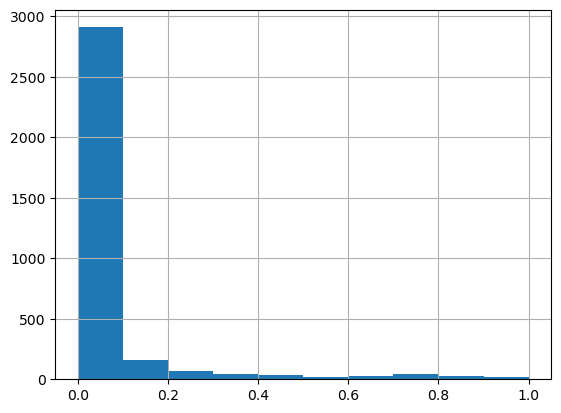

In [20]:
# We can see that there are a huge number of fields, but almost all of them are missing
# (because they are for 10-Qs or other forms)
(df_table.count(axis=0) / df_table.shape[0]).hist()

14
Index(['CIK', 'Assets', 'AssetsCurrent',
       'CashAndCashEquivalentsAtCarryingValue',
       'DeferredTaxAssetsValuationAllowance',
       'LiabilitiesAndStockholdersEquity', 'LiabilitiesCurrent',
       'NetCashProvidedByUsedInFinancingActivities',
       'NetCashProvidedByUsedInInvestingActivities',
       'NetCashProvidedByUsedInOperatingActivities', 'NetIncomeLoss',
       'OperatingIncomeLoss', 'RetainedEarningsAccumulatedDeficit',
       'StockholdersEquity'],
      dtype='object')


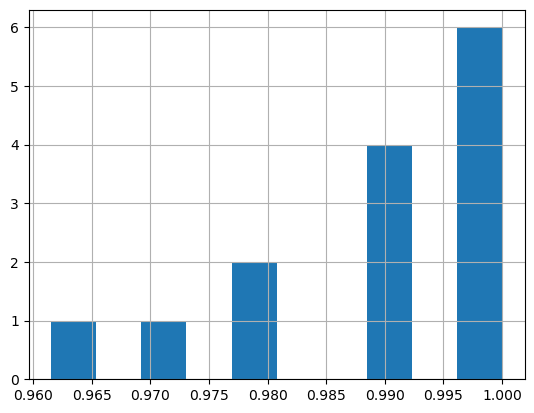

In [21]:
# What if we only took the fields that were filled out for a high percent of the companies?
FILLED_PCT_MIN = 0.95
field_filled_pct = df_table.count(axis=0) / df_table.shape[0]
df_table = df_table.loc[:, field_filled_pct >= FILLED_PCT_MIN]
print(len(df_table.columns))

# After manual inspection of these, we were reasonably happy that they captured many of the "most important" values
print(df_table.columns)

(df_table.count(axis=0) / df_table.shape[0]).hist()

# Keep only some selected columns based on their distribution
selected_cols_table = ["CIK", "Assets", "AssetsCurrent", "CashAndCashEquivalentsAtCarryingValue", "DeferredTaxAssetsValuationAllowance",
"LiabilitiesAndStockholdersEquity", "LiabilitiesCurrent", "StockholdersEquity"]

df_table = df_table[selected_cols_table]

# np.log(df_table["LiabilitiesAndStockholdersEquity"].astype(float)).hist()

/var/folders/x_/wybm3nyn2hvdps5b2tssqs9h0000gn/T/ipykernel_22364/57063981.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_table.iloc[:, 1:] = simp.fit_transform(df_table.iloc[:, 1:])


array([[<AxesSubplot: title={'center': 'Assets'}>,
        <AxesSubplot: title={'center': 'AssetsCurrent'}>,
        <AxesSubplot: title={'center': 'CashAndCashEquivalentsAtCarryingValue'}>],
       [<AxesSubplot: title={'center': 'DeferredTaxAssetsValuationAllowance'}>,
        <AxesSubplot: title={'center': 'LiabilitiesAndStockholdersEquity'}>,
        <AxesSubplot: title={'center': 'LiabilitiesCurrent'}>],
       [<AxesSubplot: title={'center': 'StockholdersEquity'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

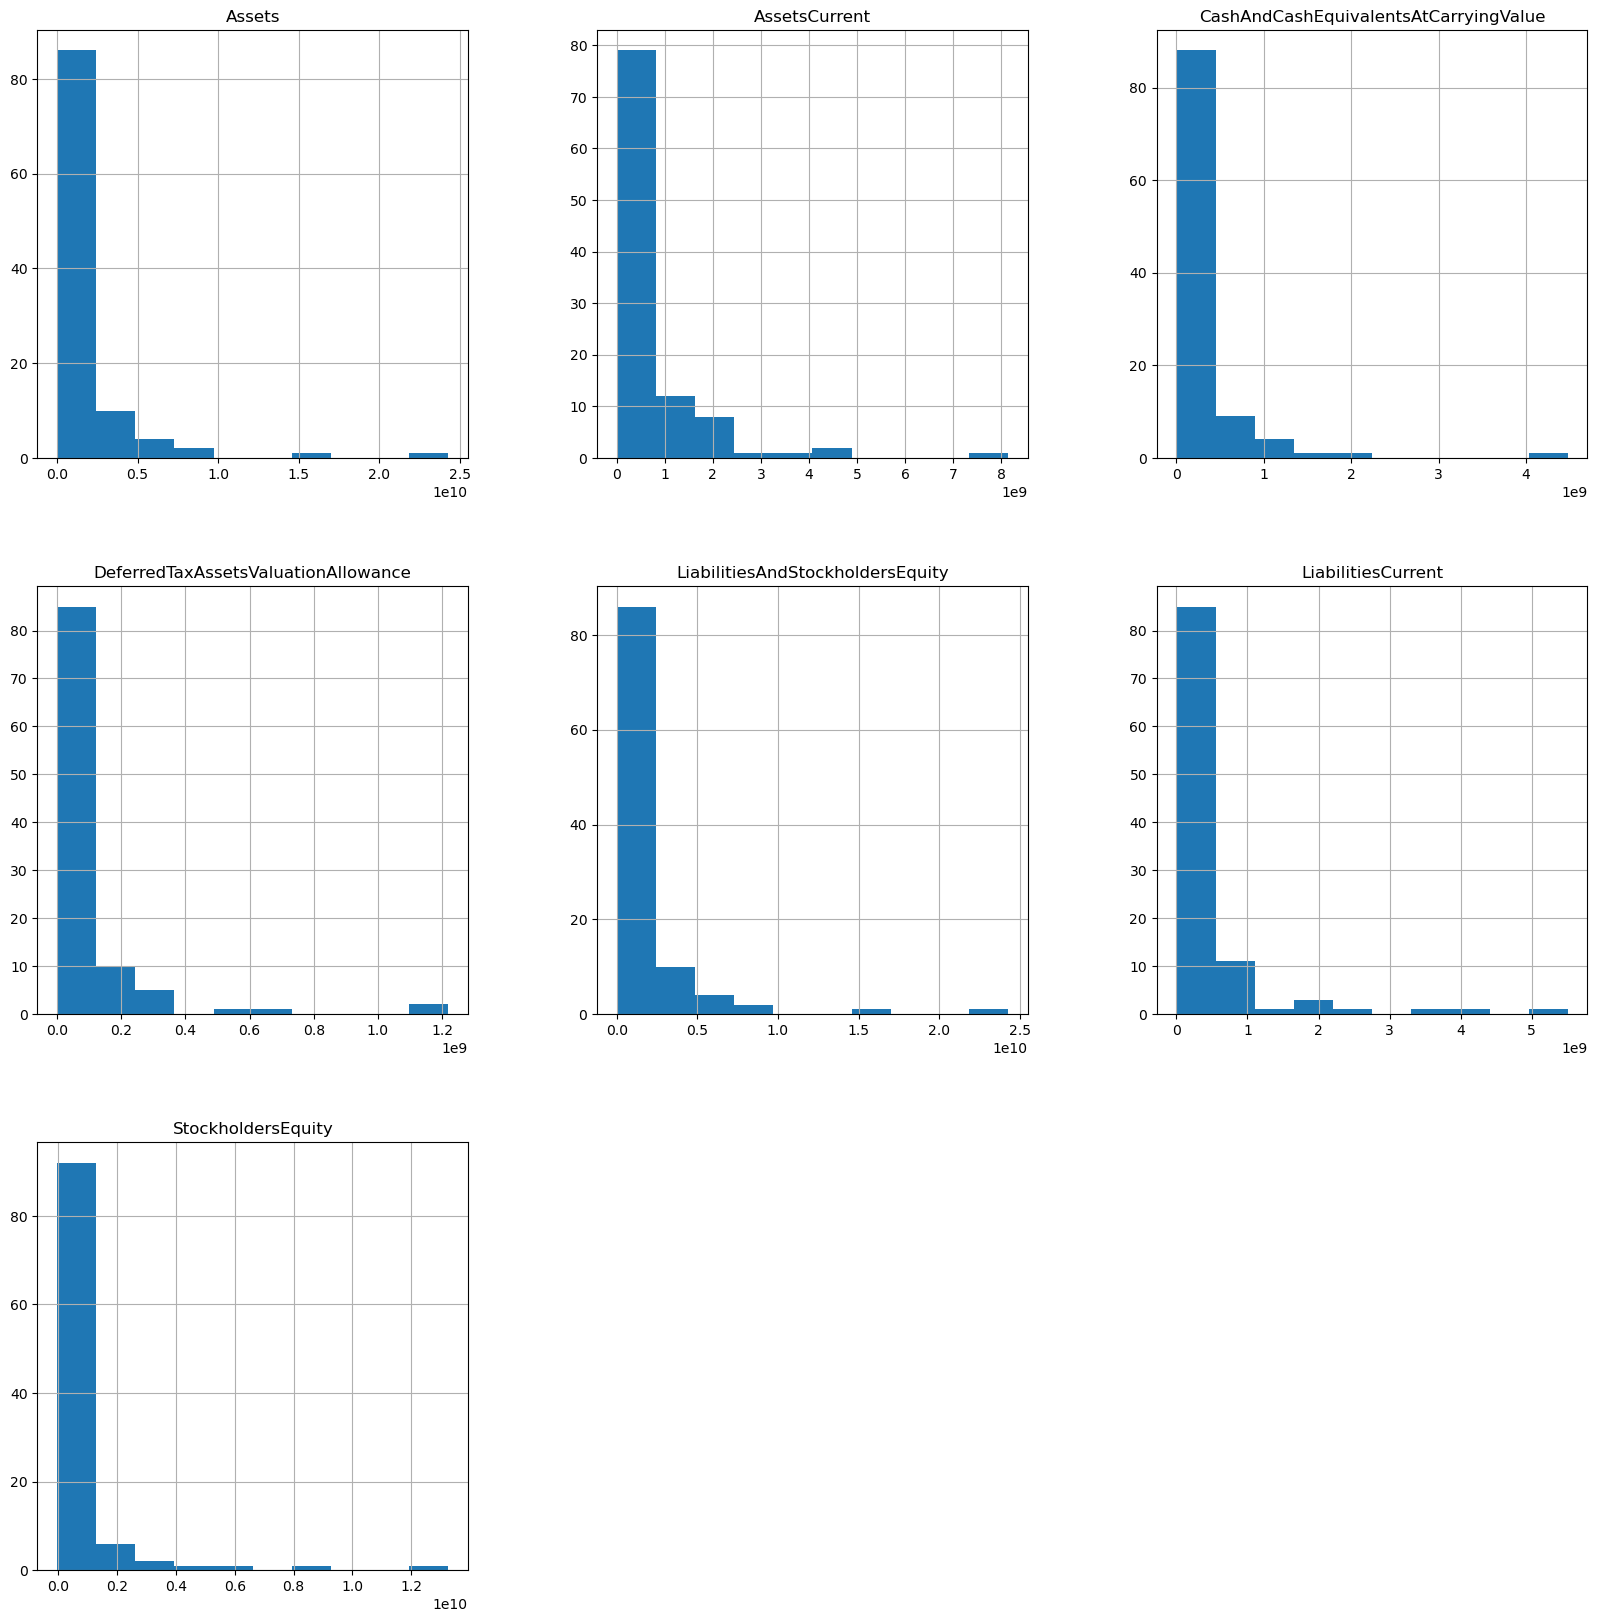

In [22]:
from sklearn.impute import SimpleImputer

# Impute missing values as median
simp = SimpleImputer(strategy='median')
df_table.iloc[:, 1:] = simp.fit_transform(df_table.iloc[:, 1:])

# Visualize distribution of all fields
df_table.iloc[:, 1:].hist(figsize=(20, 20))

array([[<AxesSubplot: title={'center': 'Assets'}>,
        <AxesSubplot: title={'center': 'AssetsCurrent'}>,
        <AxesSubplot: title={'center': 'CashAndCashEquivalentsAtCarryingValue'}>],
       [<AxesSubplot: title={'center': 'DeferredTaxAssetsValuationAllowance'}>,
        <AxesSubplot: title={'center': 'LiabilitiesAndStockholdersEquity'}>,
        <AxesSubplot: title={'center': 'LiabilitiesCurrent'}>],
       [<AxesSubplot: title={'center': 'StockholdersEquity'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

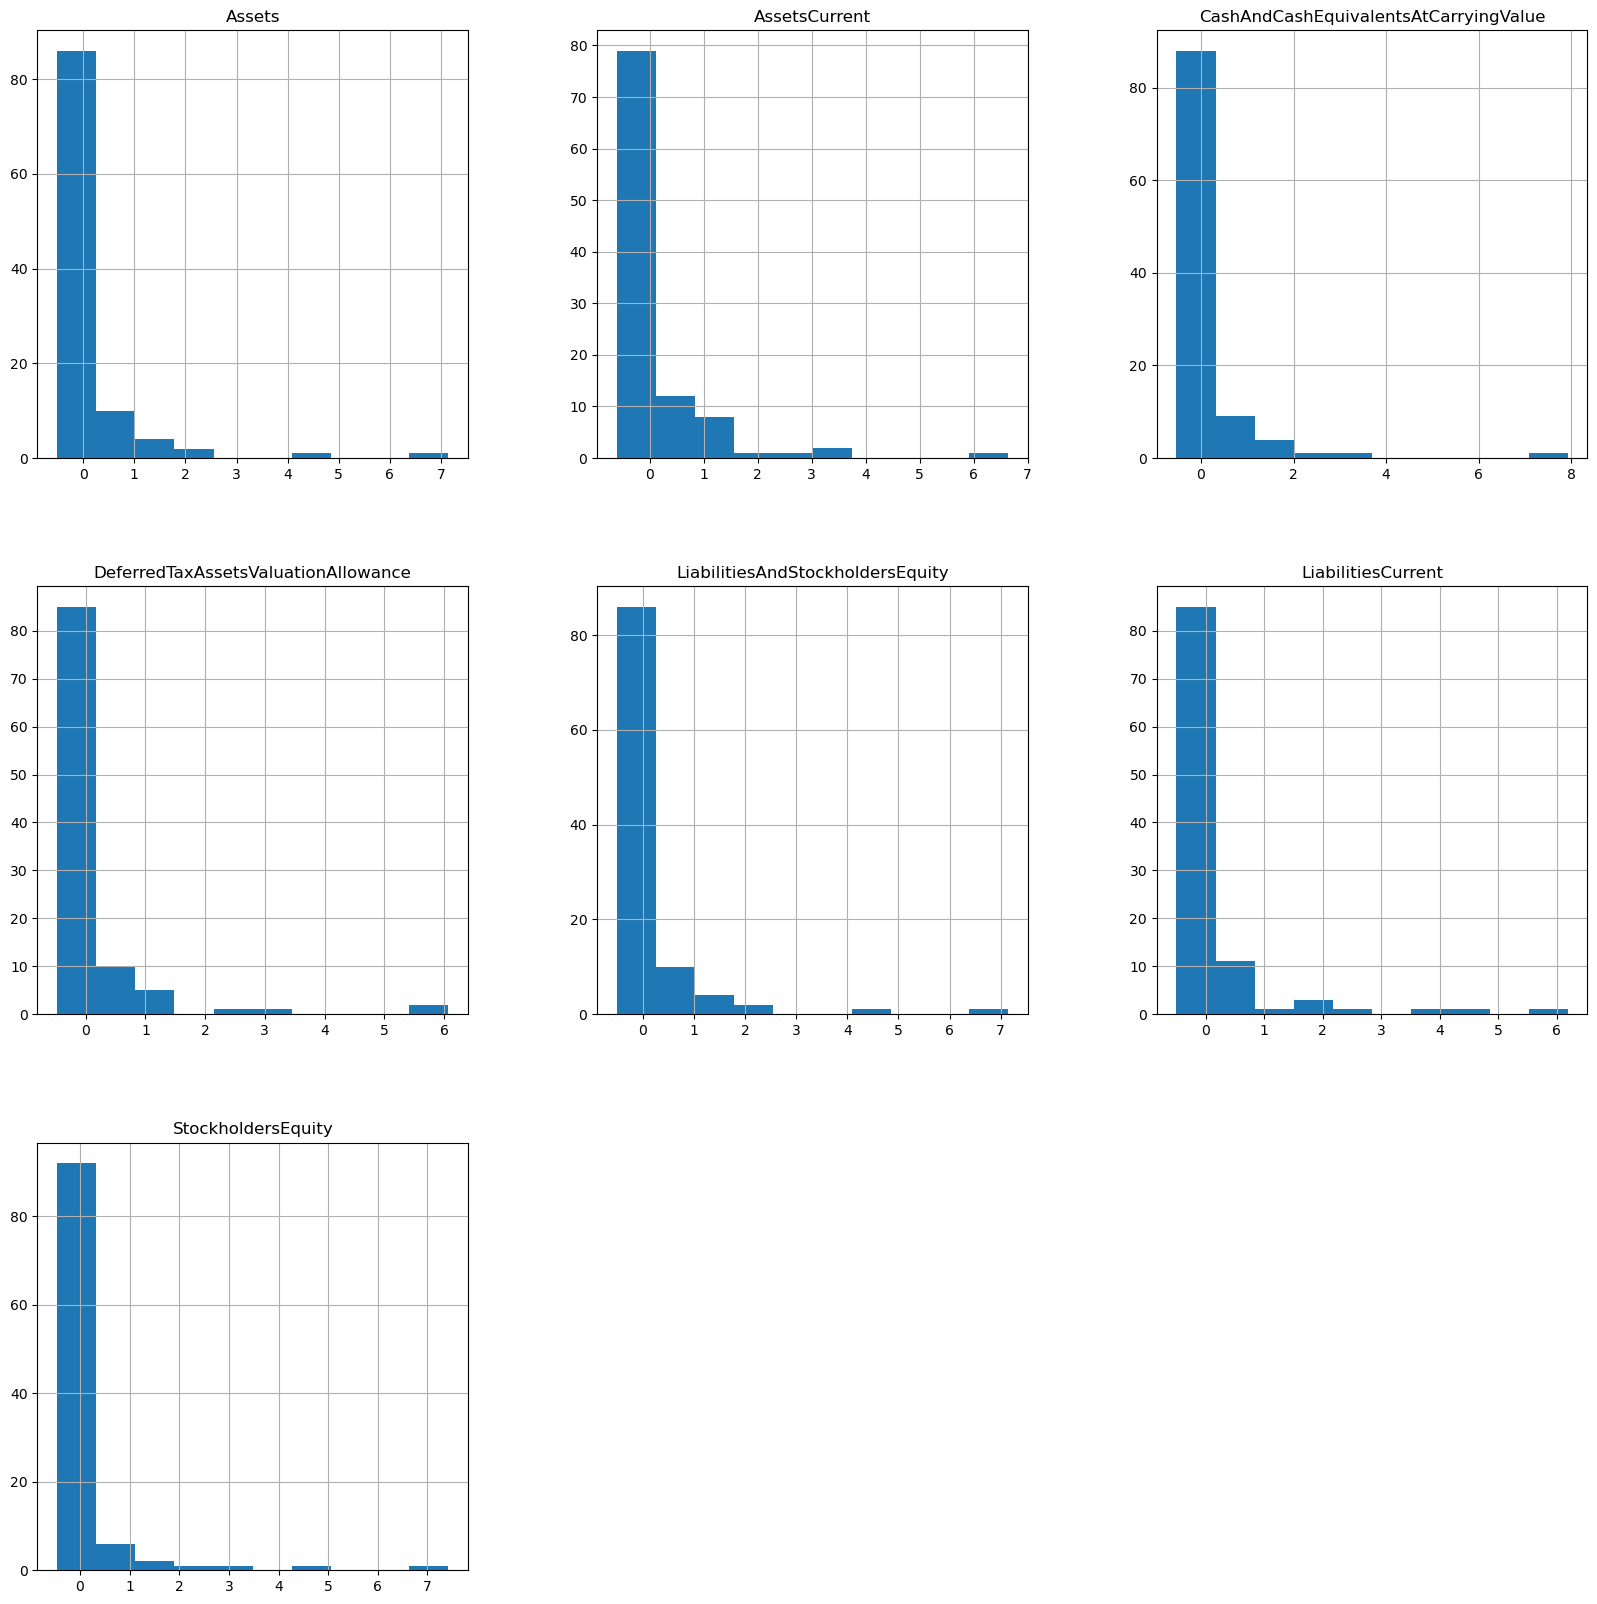

In [23]:
from sklearn.preprocessing import StandardScaler

# Standard scale features to have mean 0 and variance 1
sc = StandardScaler()
df_table.iloc[:, 1:] = sc.fit_transform(df_table.iloc[:, 1:])

# Visualize distribution of all fields
df_table.iloc[:, 1:].hist(figsize=(20, 20))

array([[<AxesSubplot: title={'center': 'Assets'}>,
        <AxesSubplot: title={'center': 'AssetsCurrent'}>,
        <AxesSubplot: title={'center': 'CashAndCashEquivalentsAtCarryingValue'}>],
       [<AxesSubplot: title={'center': 'DeferredTaxAssetsValuationAllowance'}>,
        <AxesSubplot: title={'center': 'LiabilitiesAndStockholdersEquity'}>,
        <AxesSubplot: title={'center': 'LiabilitiesCurrent'}>],
       [<AxesSubplot: title={'center': 'StockholdersEquity'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

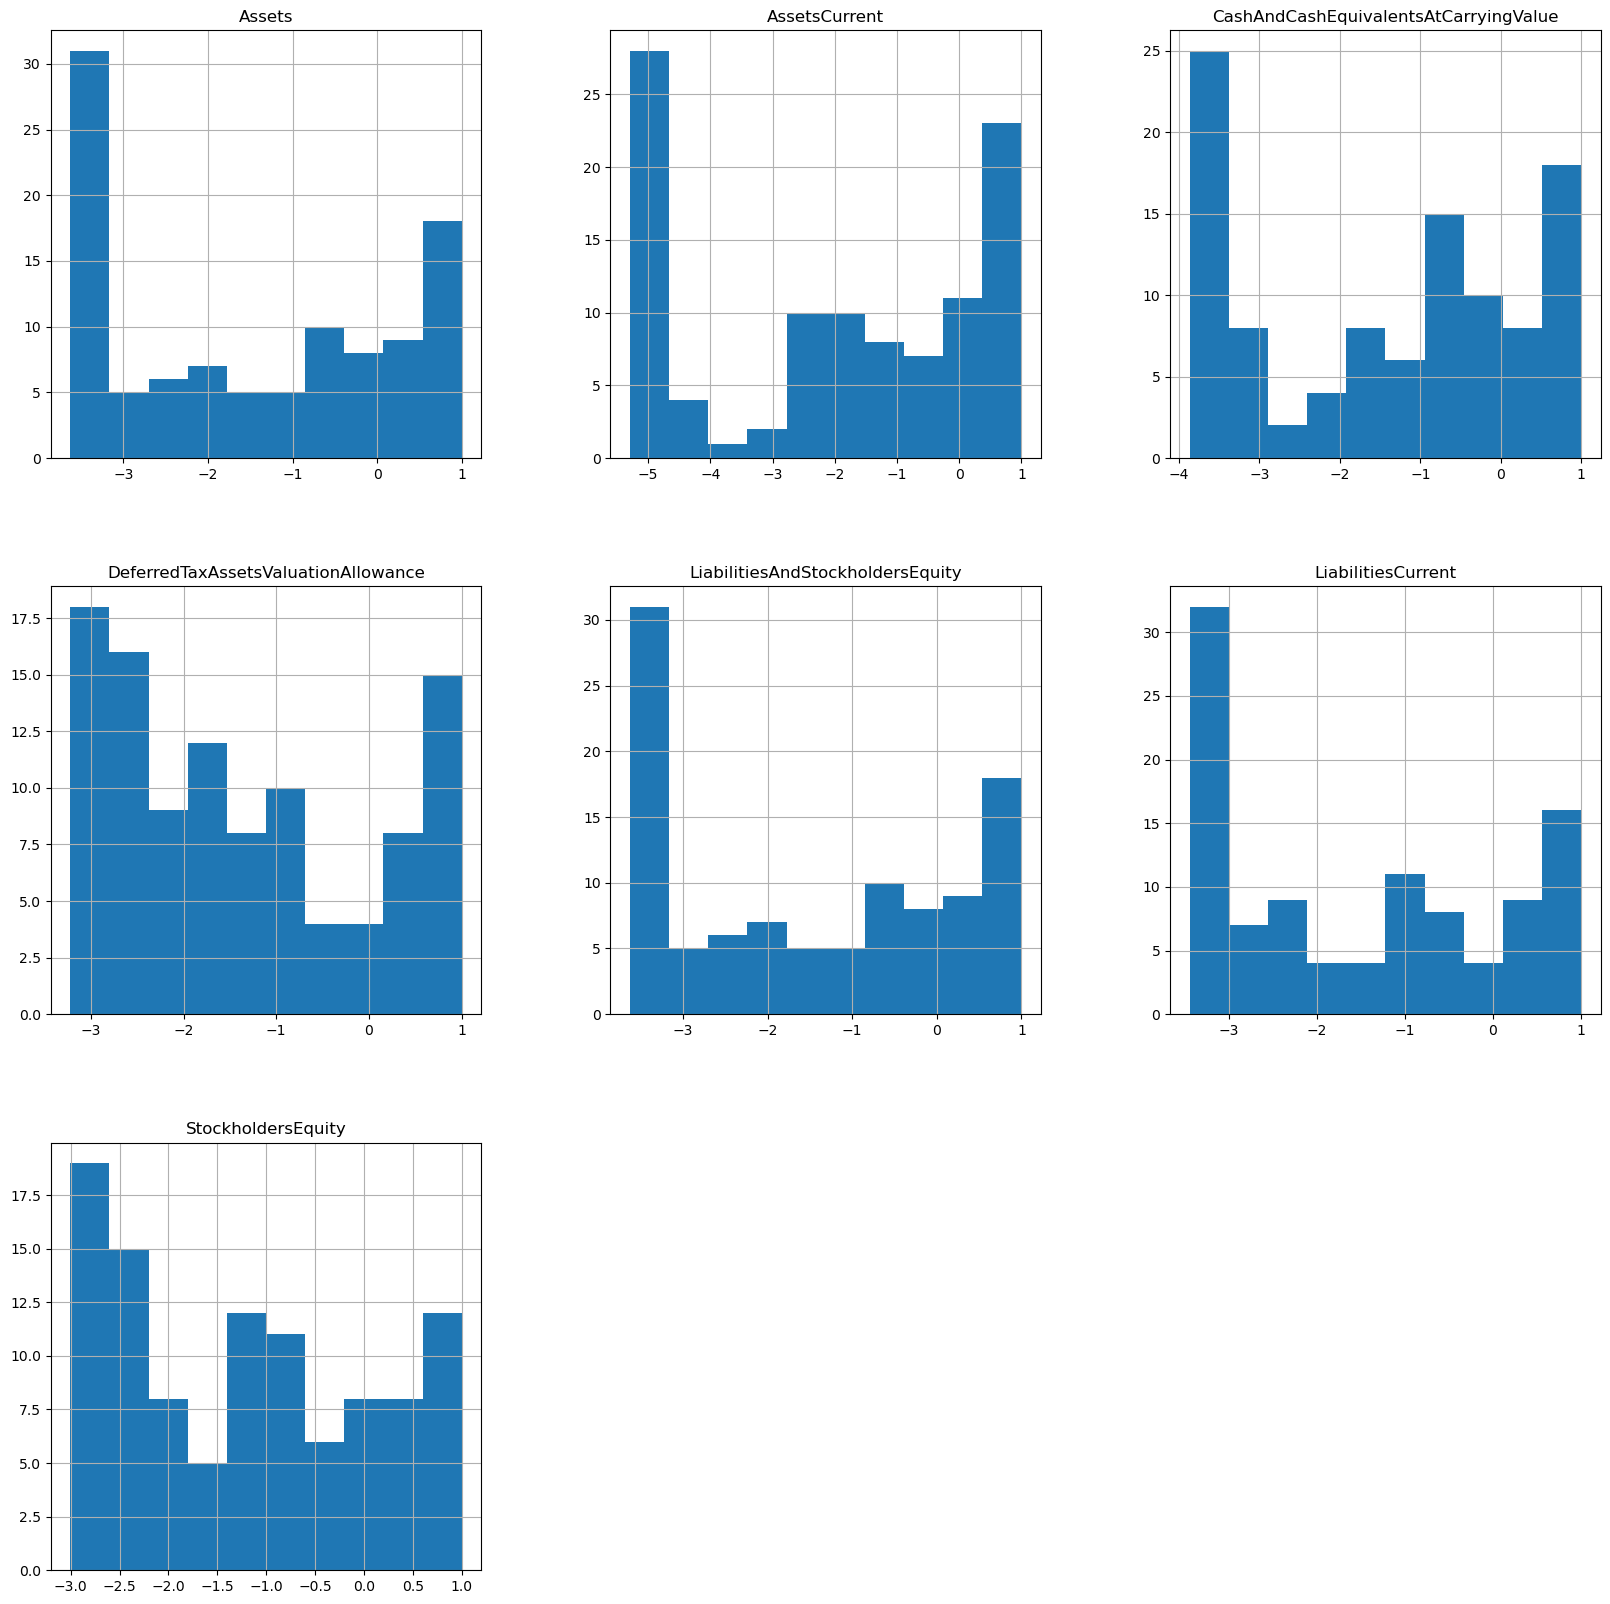

In [24]:
# We want to log normalize all the columns but some are negative or zero so this fails.
# Thus we can subtract the min (so each feature's new min is 0) and then add a tiny constant to make it always positive
#df_table.iloc[:, 1:] = np.log(df_table.iloc[:, 1:] - df_table.iloc[:, 1:].min(axis=0) + 100)

# 1 - exp(-3x)
df_table.iloc[:, 1:] = 1 - np.exp(-3*df_table.iloc[:, 1:])


# Visualize distribution of all fields
df_table.iloc[:, 1:].hist(figsize=(20, 20))

In [25]:
##########
# Join df_text and df_table on CIK

df_joined = df_text_non_tokenized.join(df_table.set_index("CIK"), on="cik", how="inner").reset_index()
df_joined = df_joined.drop(["index", "level_0"], axis=1)
print(df_joined.shape)

df_joined.head()

(104, 40)


,cik,company,filing_type,filing_date,period_of_report,sic,state_of_inc,state_location,fiscal_year_end,filing_html_index,...,item_13,item_14,item_15,Assets,AssetsCurrent,CashAndCashEquivalentsAtCarryingValue,DeferredTaxAssetsValuationAllowance,LiabilitiesAndStockholdersEquity,LiabilitiesCurrent,StockholdersEquity
0,843006,ISSUER DIRECT CORP,10-K,2021-03-04,2020-12-31,2750,None,NC,1231,https://www.sec.gov/Archives/edgar/data/843006...,...,item certain relationship related transaction ...,item principal accounting fee service informat...,item exhibit financial statement financial sta...,-3.476318,-4.927098,-3.355445,-1.608587,-3.476318,-3.369601,-2.493843
1,1567771,BRIDGEWAY NATIONAL CORP.,10-K,2021-06-01,2020-12-31,2860,DE,DC,1231,https://www.sec.gov/Archives/edgar/data/156777...,...,item certain relationship related transaction ...,item principal accounting fee service followin...,item exhibit financial statement schedule fina...,-3.622991,-5.292040,-3.865289,-3.161885,-3.622991,-3.382247,-2.696846
2,1050446,MICROSTRATEGY Inc,10-K,2021-02-12,2020-12-31,7372,DE,VA,1231,https://www.sec.gov/Archives/edgar/data/105044...,...,item certain relationship related transaction ...,item principal accountant fee service informat...,item exhibit financial statement schedule foll...,-0.156615,-2.037366,-2.470523,-3.136259,-0.156615,-0.571208,-0.374658
3,1288847,"Five9, Inc.",10-K,2021-03-01,2020-12-31,7374,DE,CA,1231,https://www.sec.gov/Archives/edgar/data/128884...,...,item certain relationship related transaction ...,item principal accountant fee service informat...,item exhibit financial statement schedule foll...,-0.691510,0.001675,-0.397337,-0.851724,-0.691510,-2.047836,-1.236506
4,1167419,"Riot Blockchain, Inc.",10-K,2021-03-31,2020-12-31,7374,NV,CO,1231,https://www.sec.gov/Archives/edgar/data/116741...,...,item certain relationship related transaction ...,item principal accountant fee service informat...,item exhibit financial statement schedule exhi...,-2.549527,-2.347161,-0.373728,-0.738080,-2.549527,-3.404439,-1.244840


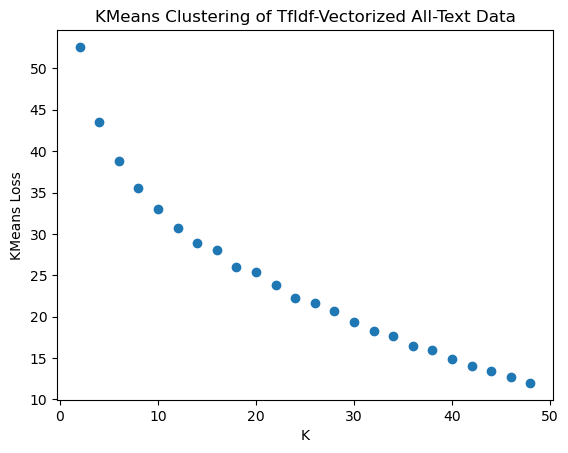

In [26]:
#########
# Preprocess df_text

from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation

# Concatenate all text fields and then vectorize the whole thing
df_joined["all_text"] = df_joined.loc[:, text_columns].sum(axis=1)

# Vectorize this concatenated string
# vec = CountVectorizer(max_df=0.95, binary=True)
vec = TfidfVectorizer(max_df=0.95, max_features=50)
X_text = vec.fit_transform(df_joined["all_text"])

#########
# Cluster X_text
losses = {}
losses_agg = {}

# cluster on text ONLY
for k in range(2, 50, 2):
    km = KMeans(n_clusters=k, random_state=1).fit(X_text)
    labels_txt_km = km.predict(X_text)
    losses[k] = km.inertia_

plt.scatter(losses.keys(), losses.values())
plt.title("KMeans Clustering of TfIdf-Vectorized All-Text Data")
plt.xlabel("K")
plt.ylabel("KMeans Loss")

# Inspect the text clusters by printing CIKs
OPTIMAL_K = 10
km = KMeans(n_clusters=OPTIMAL_K, random_state=1).fit(X_text)
labels_txt_km = km.predict(X_text)

cluster_ciks = defaultdict(list)
km_cluster_companies_text = defaultdict(list)
for row, label in enumerate(labels_txt_km):
    cluster_ciks[label].append(df_joined["cik"][row])

#print([len(cluster) for cluster in cluster_ciks.values()], cluster_ciks)

for label in cluster_ciks:
    #print("Label", label)
    #print(df_joined.set_index("cik").loc[cluster_ciks[label], "company"])
    km_cluster_companies_text[label] = df_joined.set_index("cik").loc[cluster_ciks[label], "company"]

#print(cluster_companies_text)


In [27]:
# Now try agglomerative clustering on text
agg = AgglomerativeClustering(n_clusters=OPTIMAL_K).fit(X_text.toarray())
labels_txt_agg = agg.labels_

agg_cluster_ciks = defaultdict(list)
agg_cluster_companies_text = defaultdict(list)
for row, label in enumerate(labels_txt_agg):
    agg_cluster_ciks[label].append(df_joined["cik"][row])

for label in agg_cluster_ciks:
    agg_cluster_companies_text[label] = df_joined.set_index("cik").loc[agg_cluster_ciks[label], "company"]

print([len(x) for x in agg_cluster_companies_text.values()])
print(agg_cluster_companies_text)

[28, 10, 19, 7, 13, 5, 3, 10, 5, 4]
defaultdict(<class 'list'>, {0: cik
843006               ISSUER DIRECT CORP
1433195                    APPFOLIO INC
1794515      ZoomInfo Technologies Inc.
1739942                 SolarWinds Corp
1447669                      TWILIO INC
1682325    GTY Technology Holdings Inc.
948708       SMITH MICRO SOFTWARE, INC.
1348036                   AVALARA, INC.
1679826     Ping Identity Holding Corp.
1724570             DATTO HOLDING CORP.
1810806             Unity Software Inc.
1082324            VirnetX Holding Corp
1660280          Tenable Holdings, Inc.
1517413                    Fastly, Inc.
1624512                   Boxlight Corp
1517375             Sprout Social, Inc.
1739936                       SVMK Inc.
1046327                REALNETWORKS INC
1467623                   DROPBOX, INC.
1806837                    Vertex, Inc.
1721947              Jamf Holding Corp.
1169652             CHANNELADVISOR CORP
1459200        Alarm.com Holdings, Inc.
1800667 

In [28]:
# Now try affinitypropagation clustering on text
aff = AffinityPropagation(random_state=1).fit(X_text.toarray())
labels_txt_aff = aff.labels_

aff_cluster_ciks = defaultdict(list)
aff_cluster_companies_text = defaultdict(list)
for row, label in enumerate(labels_txt_aff):
    aff_cluster_ciks[label].append(df_joined["cik"][row])

for label in aff_cluster_ciks:
    aff_cluster_companies_text[label] = df_joined.set_index("cik").loc[aff_cluster_ciks[label], "company"]

print([len(x) for x in aff_cluster_companies_text.values()])
print(aff_cluster_companies_text)

[19, 15, 10, 8, 7, 10, 3, 10, 5, 8, 4, 4, 1]
defaultdict(<class 'list'>, {0: cik
843006                        ISSUER DIRECT CORP
1031308                      BENTLEY SYSTEMS INC
1433195                             APPFOLIO INC
1739942                          SolarWinds Corp
1392972                      PROS Holdings, Inc.
1561550                            Datadog, Inc.
1321655               Palantir Technologies Inc.
1627857    Sailpoint Technologies Holdings, Inc.
1477333                         Cloudflare, Inc.
1666134                          BLACKLINE, INC.
1660280                   Tenable Holdings, Inc.
1517413                             Fastly, Inc.
1560327                             Rapid7, Inc.
1806837                             Vertex, Inc.
1800667                                JFrog Ltd
1351636                         SHOTSPOTTER, INC
1373715                         ServiceNow, Inc.
1410384                        Q2 Holdings, Inc.
1015739                           AWA

In [29]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=OPTIMAL_K, random_state=0).fit(X_text.toarray())
labels_txt_gm = gm.predict(X_text.toarray())

gm_cluster_ciks = defaultdict(list)
gm_cluster_companies_text = defaultdict(list)
for row, label in enumerate(labels_txt_gm):
    gm_cluster_ciks[label].append(df_joined["cik"][row])

for label in gm_cluster_ciks:
    gm_cluster_companies_text[label] = df_joined.set_index("cik").loc[gm_cluster_ciks[label], "company"]

print([len(x) for x in gm_cluster_companies_text.values()])
print(gm_cluster_companies_text)

[17, 17, 18, 8, 13, 6, 4, 12, 2, 7]
defaultdict(<class 'list'>, {1: cik
843006               ISSUER DIRECT CORP
1433195                    APPFOLIO INC
1739942                 SolarWinds Corp
1682325    GTY Technology Holdings Inc.
948708       SMITH MICRO SOFTWARE, INC.
1348036                   AVALARA, INC.
1810806             Unity Software Inc.
1082324            VirnetX Holding Corp
1517375             Sprout Social, Inc.
1739936                       SVMK Inc.
1467623                   DROPBOX, INC.
1721947              Jamf Holding Corp.
1169652             CHANNELADVISOR CORP
1044777                    OneSpan Inc.
1803696              Xperi Holding Corp
1351636                SHOTSPOTTER, INC
1015739                  AWARE INC /MA/
Name: company, dtype: object, 2: cik
1567771         BRIDGEWAY NATIONAL CORP.
1167419            Riot Blockchain, Inc.
1362190                     AUDIOEYE INC
746210                      Oblong, Inc.
1001601    MGT CAPITAL INVESTMENTS, INC.
156790

defaultdict(<class 'list'>, {1: cik
843006                          ISSUER DIRECT CORP
1567771                   BRIDGEWAY NATIONAL CORP.
1054721                           BSQUARE CORP /WA
1052054                       EVOLVING SYSTEMS INC
1362190                               AUDIOEYE INC
746210                                Oblong, Inc.
944480                             GSE SYSTEMS INC
1064722                           GIVEMEPOWER CORP
1001601              MGT CAPITAL INVESTMENTS, INC.
736012                               INTRUSION INC
1682325               GTY Technology Holdings Inc.
1567900                        BLACKBOXSTOCKS INC.
948708                  SMITH MICRO SOFTWARE, INC.
941685                       IMAGEWARE SYSTEMS INC
1084577                                 CYREN Ltd.
1389002                         MARIN SOFTWARE INC
320340                    INTELLIGENT SYSTEMS CORP
1624512                              Boxlight Corp
1046327                           REALNETWORKS

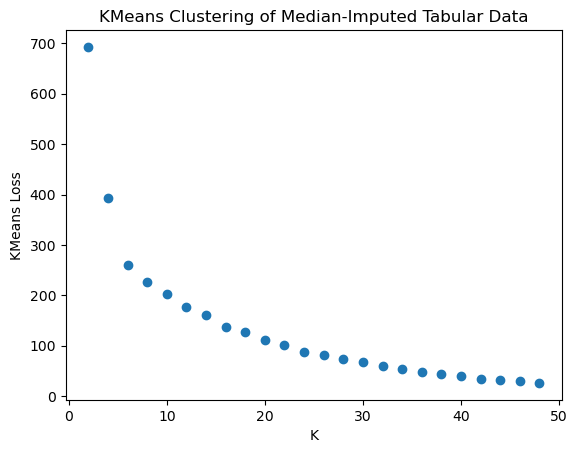

In [30]:
#######
# cluster on tabular/financials ONLY
X_table = df_joined[df_table.columns[1:]]

# use kmeans
losses = {}

for k in range(2, 50, 2):
    km = KMeans(n_clusters=k, random_state=1).fit(X_table)
    labels_tab_km = km.predict(X_table)
    losses[k] = km.inertia_

plt.scatter(losses.keys(), losses.values())
plt.title("KMeans Clustering of Median-Imputed Tabular Data")
plt.xlabel("K")
plt.ylabel("KMeans Loss")

# Inspect the tabular clusters by printing CIKs
OPTIMAL_K = 10
km = KMeans(n_clusters=OPTIMAL_K, random_state=1).fit(X_table)
labels_tab_km = km.predict(X_table)

cluster_ciks = defaultdict(list)
km_cluster_companies_table = defaultdict(list)
for row, label in enumerate(labels_tab_km):
    cluster_ciks[label].append(df_joined["cik"][row])

#print([len(cluster) for cluster in cluster_ciks.values()], cluster_ciks)

for label in cluster_ciks:
    #print("Label", label)
    #print(df_joined.set_index("cik").loc[cluster_ciks[label], "company"])
    km_cluster_companies_table[label] = df_joined.set_index("cik").loc[cluster_ciks[label], "company"]

print(km_cluster_companies_table)

In [31]:
# Now try agglomerative clustering on tabular
agg = AgglomerativeClustering(n_clusters=OPTIMAL_K).fit(X_table)
labels_tab_agg = agg.labels_

agg_cluster_ciks = defaultdict(list)
agg_cluster_companies_tab = defaultdict(list)
for row, label in enumerate(labels_tab_agg):
    agg_cluster_ciks[label].append(df_joined["cik"][row])

for label in agg_cluster_ciks:
    agg_cluster_companies_tab[label] = df_joined.set_index("cik").loc[agg_cluster_ciks[label], "company"]

print([len(x) for x in agg_cluster_companies_tab.values()])
print(agg_cluster_companies_tab)

[25, 10, 12, 8, 8, 9, 6, 6, 12, 8]
defaultdict(<class 'list'>, {3: cik
843006                          ISSUER DIRECT CORP
1567771                   BRIDGEWAY NATIONAL CORP.
1054721                           BSQUARE CORP /WA
1052054                       EVOLVING SYSTEMS INC
1362190                               AUDIOEYE INC
944480                             GSE SYSTEMS INC
1064722                           GIVEMEPOWER CORP
1001601              MGT CAPITAL INVESTMENTS, INC.
736012                               INTRUSION INC
1682325               GTY Technology Holdings Inc.
941685                       IMAGEWARE SYSTEMS INC
320340                    INTELLIGENT SYSTEMS CORP
1624512                              Boxlight Corp
1467761                     Zoom Telephonics, Inc.
922521                     FALCONSTOR SOFTWARE INC
1353499                             Max Sound Corp
1017655                                   PAID INC
1081745                        INTELLINETICS, INC.
1351636    

In [55]:
gm = GaussianMixture(n_components=OPTIMAL_K, random_state=0).fit(X_table)
labels_tab_gm = gm.predict(X_table)

gm_cluster_ciks = defaultdict(list)
gm_cluster_companies_tab = defaultdict(list)
for row, label in enumerate(labels_tab_gm):
    gm_cluster_ciks[label].append(df_joined["cik"][row])

for label in gm_cluster_ciks:
    gm_cluster_companies_tab[label] = df_joined.set_index("cik").loc[gm_cluster_ciks[label], "company"]

print([len(x) for x in gm_cluster_companies_tab.values()])
print(gm_cluster_companies_tab)

[25, 7, 11, 9, 9, 14, 6, 14, 3, 6]
defaultdict(<class 'list'>, {8: cik
843006                          ISSUER DIRECT CORP
1567771                   BRIDGEWAY NATIONAL CORP.
1054721                           BSQUARE CORP /WA
1052054                       EVOLVING SYSTEMS INC
1362190                               AUDIOEYE INC
944480                             GSE SYSTEMS INC
1064722                           GIVEMEPOWER CORP
1001601              MGT CAPITAL INVESTMENTS, INC.
736012                               INTRUSION INC
948708                  SMITH MICRO SOFTWARE, INC.
941685                       IMAGEWARE SYSTEMS INC
1084577                                 CYREN Ltd.
1389002                         MARIN SOFTWARE INC
1046327                           REALNETWORKS INC
922521                     FALCONSTOR SOFTWARE INC
829323                                 Inuvo, Inc.
1017655                                   PAID INC
1081745                        INTELLINETICS, INC.
1351636    

defaultdict(<class 'list'>, {4: cik
843006                          ISSUER DIRECT CORP
1567771                   BRIDGEWAY NATIONAL CORP.
1054721                           BSQUARE CORP /WA
1052054                       EVOLVING SYSTEMS INC
1362190                               AUDIOEYE INC
944480                             GSE SYSTEMS INC
1064722                           GIVEMEPOWER CORP
1001601              MGT CAPITAL INVESTMENTS, INC.
736012                               INTRUSION INC
1682325               GTY Technology Holdings Inc.
948708                  SMITH MICRO SOFTWARE, INC.
941685                       IMAGEWARE SYSTEMS INC
1084577                                 CYREN Ltd.
1389002                         MARIN SOFTWARE INC
320340                    INTELLIGENT SYSTEMS CORP
1624512                              Boxlight Corp
1046327                           REALNETWORKS INC
1467761                     Zoom Telephonics, Inc.
922521                     FALCONSTOR SOFTWARE

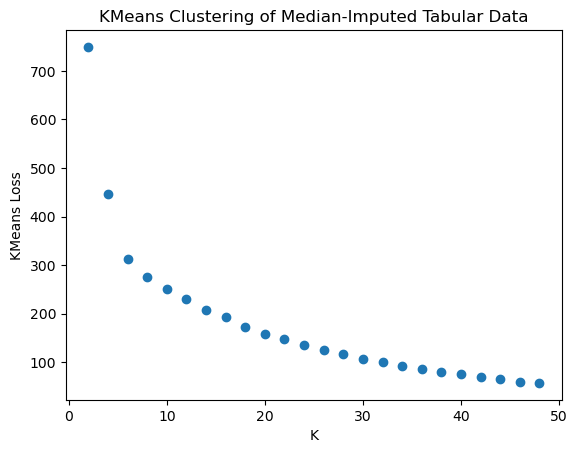

In [56]:
from scipy.sparse import hstack

#######
# cluster on tabular AND text
X_both = hstack((X_table, X_text))

# use kmeans
losses = {}

for k in range(2, 50, 2):
    km = KMeans(n_clusters=k, random_state=1).fit(X_both)
    labels_both_km = km.predict(X_both)
    losses[k] = km.inertia_

plt.scatter(losses.keys(), losses.values())
plt.title("KMeans Clustering of Median-Imputed Tabular Data")
plt.xlabel("K")
plt.ylabel("KMeans Loss")

# Inspect the tabular clusters by printing CIKs
OPTIMAL_K = 10
km = KMeans(n_clusters=OPTIMAL_K, random_state=1).fit(X_both)
labels_both_km = km.predict(X_both)

cluster_ciks = defaultdict(list)
km_cluster_companies_both = defaultdict(list)
for row, label in enumerate(labels_both_km):
    cluster_ciks[label].append(df_joined["cik"][row])

#print([len(cluster) for cluster in cluster_ciks.values()], cluster_ciks)

for label in cluster_ciks:
    #print("Label", label)
    #print(df_joined.set_index("cik").loc[cluster_ciks[label], "company"])
    km_cluster_companies_both[label] = df_joined.set_index("cik").loc[cluster_ciks[label], "company"]

print(km_cluster_companies_both)

In [57]:
# Now try agglomerative clustering on both
agg = AgglomerativeClustering(n_clusters=OPTIMAL_K).fit(X_both.toarray())
labels_both_agg = agg.labels_

agg_cluster_ciks = defaultdict(list)
agg_cluster_companies_both = defaultdict(list)
for row, label in enumerate(labels_both_agg):
    agg_cluster_ciks[label].append(df_joined["cik"][row])

for label in agg_cluster_ciks:
    agg_cluster_companies_both[label] = df_joined.set_index("cik").loc[agg_cluster_ciks[label], "company"]

print([len(x) for x in agg_cluster_companies_both.values()])
print(agg_cluster_companies_both)

[31, 10, 11, 9, 8, 9, 5, 6, 13, 2]
defaultdict(<class 'list'>, {1: cik
843006                          ISSUER DIRECT CORP
1567771                   BRIDGEWAY NATIONAL CORP.
1054721                           BSQUARE CORP /WA
1052054                       EVOLVING SYSTEMS INC
1362190                               AUDIOEYE INC
944480                             GSE SYSTEMS INC
1064722                           GIVEMEPOWER CORP
1001601              MGT CAPITAL INVESTMENTS, INC.
736012                               INTRUSION INC
1682325               GTY Technology Holdings Inc.
948708                  SMITH MICRO SOFTWARE, INC.
941685                       IMAGEWARE SYSTEMS INC
1084577                                 CYREN Ltd.
1389002                         MARIN SOFTWARE INC
320340                    INTELLIGENT SYSTEMS CORP
1624512                              Boxlight Corp
1046327                           REALNETWORKS INC
1467761                     Zoom Telephonics, Inc.
922521     

In [58]:
gm = GaussianMixture(n_components=OPTIMAL_K, random_state=0).fit(X_both.toarray())
labels_both_gm = gm.predict(X_both.toarray())

gm_cluster_ciks = defaultdict(list)
gm_cluster_companies_both = defaultdict(list)
for row, label in enumerate(labels_both_gm):
    gm_cluster_ciks[label].append(df_joined["cik"][row])

for label in gm_cluster_ciks:
    gm_cluster_companies_both[label] = df_joined.set_index("cik").loc[gm_cluster_ciks[label], "company"]

print([len(x) for x in gm_cluster_companies_both.values()])
print(gm_cluster_companies_both)

[16, 16, 8, 7, 8, 10, 10, 13, 14, 2]
defaultdict(<class 'list'>, {8: cik
843006                          ISSUER DIRECT CORP
1054721                           BSQUARE CORP /WA
1001601              MGT CAPITAL INVESTMENTS, INC.
948708                  SMITH MICRO SOFTWARE, INC.
941685                       IMAGEWARE SYSTEMS INC
1084577                                 CYREN Ltd.
1389002                         MARIN SOFTWARE INC
1046327                           REALNETWORKS INC
922521                     FALCONSTOR SOFTWARE INC
829323                                 Inuvo, Inc.
1353499                             Max Sound Corp
1169652                        CHANNELADVISOR CORP
1351636                           SHOTSPOTTER, INC
1084384                              PARETEUM Corp
892482                                   Qumu Corp
1342936    Advanced Voice Recognition Systems, Inc
Name: company, dtype: object, 1: cik
1567771        BRIDGEWAY NATIONAL CORP.
1052054            EVOLVING SYSTEM

In [59]:
from sklearn.metrics import silhouette_score

print("KMEANS Labels")
print(silhouette_score(X_text, labels_txt_km))
print(silhouette_score(X_table, labels_tab_km))
print(silhouette_score(X_both, labels_both_km))

print("AgglomerativeClustering Labels")
print(silhouette_score(X_text, labels_txt_agg))
print(silhouette_score(X_table, labels_tab_agg))
print(silhouette_score(X_table, labels_both_agg))

print("GMM Labels")
print(silhouette_score(X_text, labels_txt_gm))
print(silhouette_score(X_table, labels_tab_gm))
print(silhouette_score(X_both, labels_both_gm))


KMEANS Labels
0.13210900267166353
0.3743888677508721
0.2803745827950248
AgglomerativeClustering Labels
0.1406011938902328
0.2784350157850302
0.34028751796601653
GMM Labels
0.1067605877244186
0.3050893658083238
0.23707733857840538


In [69]:
# Picked GMM
labels_tab, labels_txt, labels_both = labels_tab_agg, labels_txt_agg, labels_both_agg

In [70]:
# Compare similarity of clusterings on TEXT ONLY and TABULAR ONLY
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score

print("KMEANS")
print("TAB vs TXT")
print("Adj Rand score:", adjusted_rand_score(labels_tab_km, labels_txt_km))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_tab_km, labels_txt_km))

print("BOTH vs TXT")
print("Adj Rand score:", adjusted_rand_score(labels_both_km, labels_txt_km))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_both_km, labels_txt_km))

print("BOTH vs TAB")
print("Adj Rand score:", adjusted_rand_score(labels_both_km, labels_tab_km))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_both_km, labels_tab_km))

print("GMM")
print("TAB vs TXT")
print("Adj Rand score:", adjusted_rand_score(labels_tab_gm, labels_txt_gm))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_tab_gm, labels_txt_gm))

print("BOTH vs TXT")
print("Adj Rand score:", adjusted_rand_score(labels_both_gm, labels_txt_gm))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_both_gm, labels_txt_gm))

print("BOTH vs TAB")
print("Adj Rand score:", adjusted_rand_score(labels_both_gm, labels_tab_gm))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_both_gm, labels_tab_gm))

print("AGGLOMERATIVE")
print("TAB vs TXT")
print("Adj Rand score:", adjusted_rand_score(labels_tab_agg, labels_txt_agg))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_tab_agg, labels_txt_agg))

print("BOTH vs TXT")
print("Adj Rand score:", adjusted_rand_score(labels_both_agg, labels_txt_agg))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_both_agg, labels_txt_agg))

print("BOTH vs TAB")
print("Adj Rand score:", adjusted_rand_score(labels_both_agg, labels_tab_agg))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_both_agg, labels_tab_agg))

KMEANS
TAB vs TXT
Adj Rand score: 0.044878337176403646
Adj mutual info score: 0.11705225642197618
BOTH vs TXT
Adj Rand score: 0.050257894264255594
Adj mutual info score: 0.12627847819999027
BOTH vs TAB
Adj Rand score: 0.8218534426367642
Adj mutual info score: 0.7913566897049432
GMM
TAB vs TXT
Adj Rand score: 0.07824309307908286
Adj mutual info score: 0.1253032576739655
BOTH vs TXT
Adj Rand score: 0.08720741520482406
Adj mutual info score: 0.17063137798633862
BOTH vs TAB
Adj Rand score: 0.7028666492635379
Adj mutual info score: 0.8072784770829106
AGGLOMERATIVE
TAB vs TXT
Adj Rand score: 0.03493210643919559
Adj mutual info score: 0.10111159141338563
BOTH vs TXT
Adj Rand score: 0.03325278090354
Adj mutual info score: 0.10835764296876145
BOTH vs TAB
Adj Rand score: 0.8371649021519658
Adj mutual info score: 0.9087763994185825


/Users/keyur/mambaforge/envs/AML/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


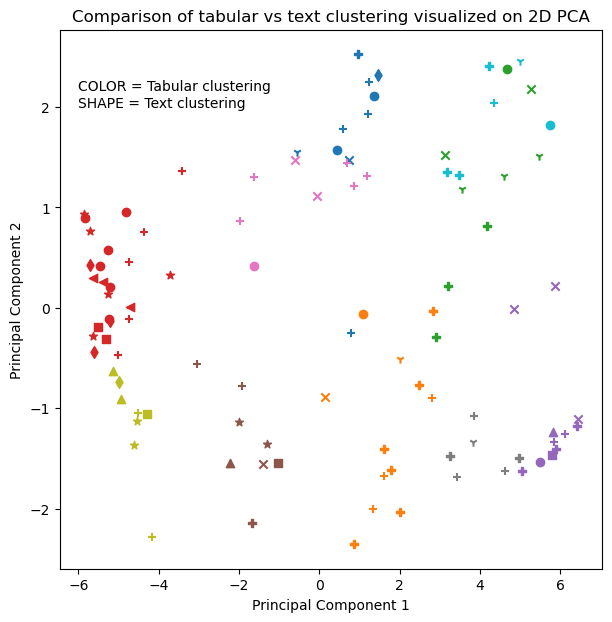

In [71]:
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors

pca = PCA(n_components=2)
X_both_pca = pca.fit_transform(X_both.todense())

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()

# map to colors
colors = {i:c for i, c in enumerate(list(mcolors.TABLEAU_COLORS)[:10])}
mapped_colors = []
  
for label in labels_tab:
  mapped_colors.append(colors[label])

# map to markers
markers = {0: "+", 1: "P", 2: "o", 3:"*", 4:"x", 5:"^", 6:"s", 7:"d", 8:"1", 9:"<"}
mapped_markers = []

for label in labels_txt:
  mapped_markers.append(markers[label])


for _s, c, _x, _y in zip(mapped_markers, mapped_colors, X_both_pca[:,0], X_both_pca[:,1]):
  ax.scatter(_x, _y, marker=_s, c=c)

#ax.scatter(X_both_pca[:,0], X_both_pca[:,1], c=labels_txt)
plt.text(-6, 2, "COLOR = Tabular clustering\nSHAPE = Text clustering")
plt.title("Comparison of tabular vs text clustering visualized on 2D PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.show()


/Users/keyur/mambaforge/envs/AML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/keyur/mambaforge/envs/AML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/keyur/mambaforge/envs/AML/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


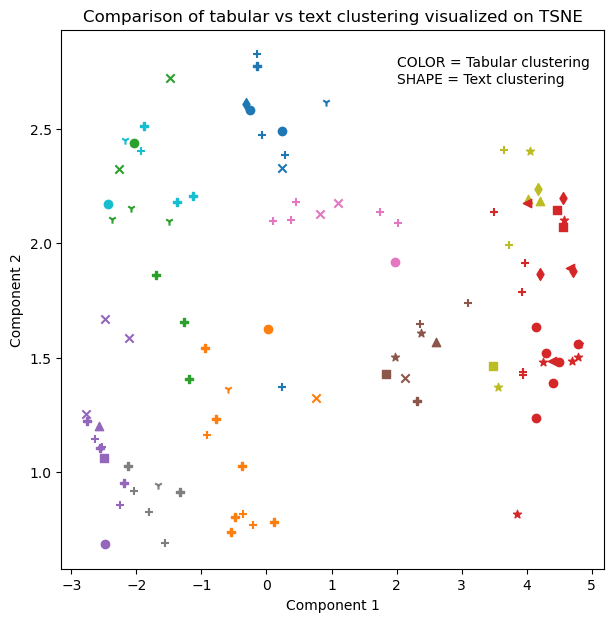

In [72]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, random_state=1)

X_both_tsne = tsne.fit_transform(X_both.todense())

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()

# map to colors
colors = {i:c for i, c in enumerate(list(mcolors.TABLEAU_COLORS)[:10])}
mapped_colors = []
  
for label in labels_tab:
  mapped_colors.append(colors[label])

# map to markers
markers = {0: "+", 1: "P", 2: "o", 3:"*", 4:"x", 5:"^", 6:"s", 7:"d", 8:"1", 9:"<"}
mapped_markers = []

for label in labels_txt:
  mapped_markers.append(markers[label])


for _s, c, _x, _y in zip(mapped_markers, mapped_colors, X_both_tsne[:,0], X_both_tsne[:,1]):
  ax.scatter(_x, _y, marker=_s, c=c)

plt.text(2, 2.7, "COLOR = Tabular clustering\nSHAPE = Text clustering")
plt.title("Comparison of tabular vs text clustering visualized on TSNE")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.show()

/Users/keyur/mambaforge/envs/AML/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


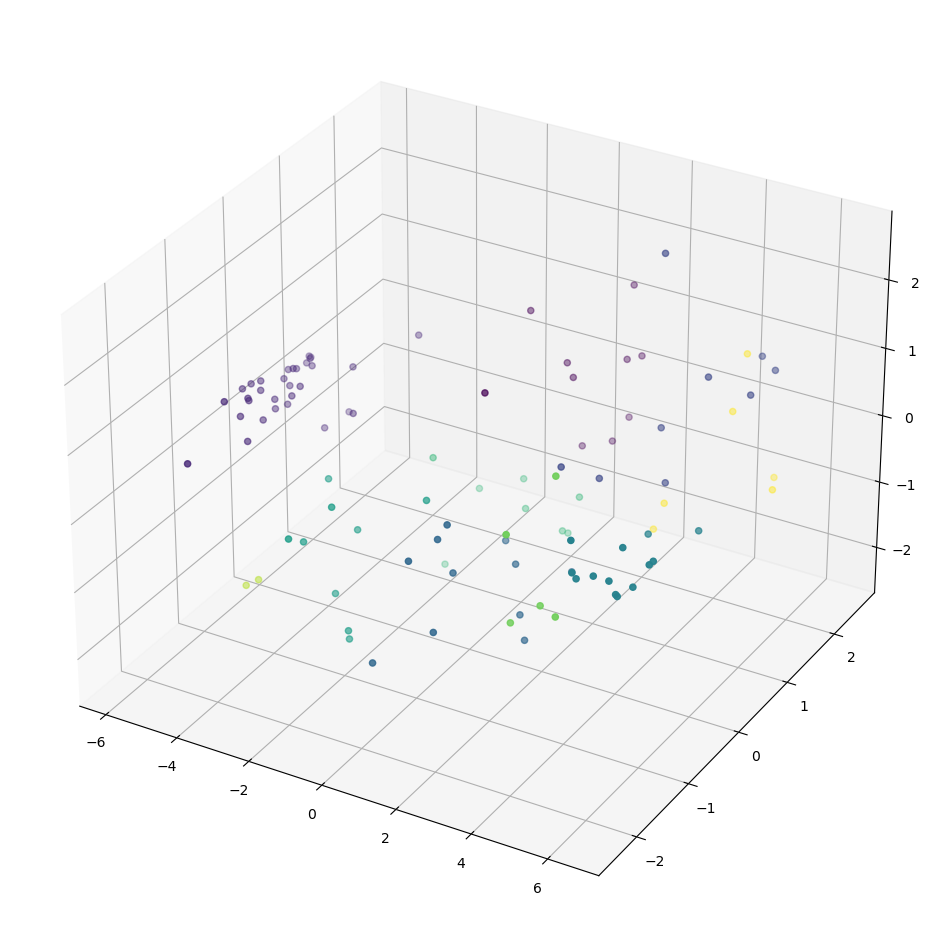

In [73]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_both_pca = pca.fit_transform(X_both.todense())

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_both_pca[:,0], X_both_pca[:,1], X_both_pca[:,2], c=labels_both)

plt.show()

/Users/keyur/mambaforge/envs/AML/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/keyur/mambaforge/envs/AML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/keyur/mambaforge/envs/AML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/keyur/mambaforge/envs/AML/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information se

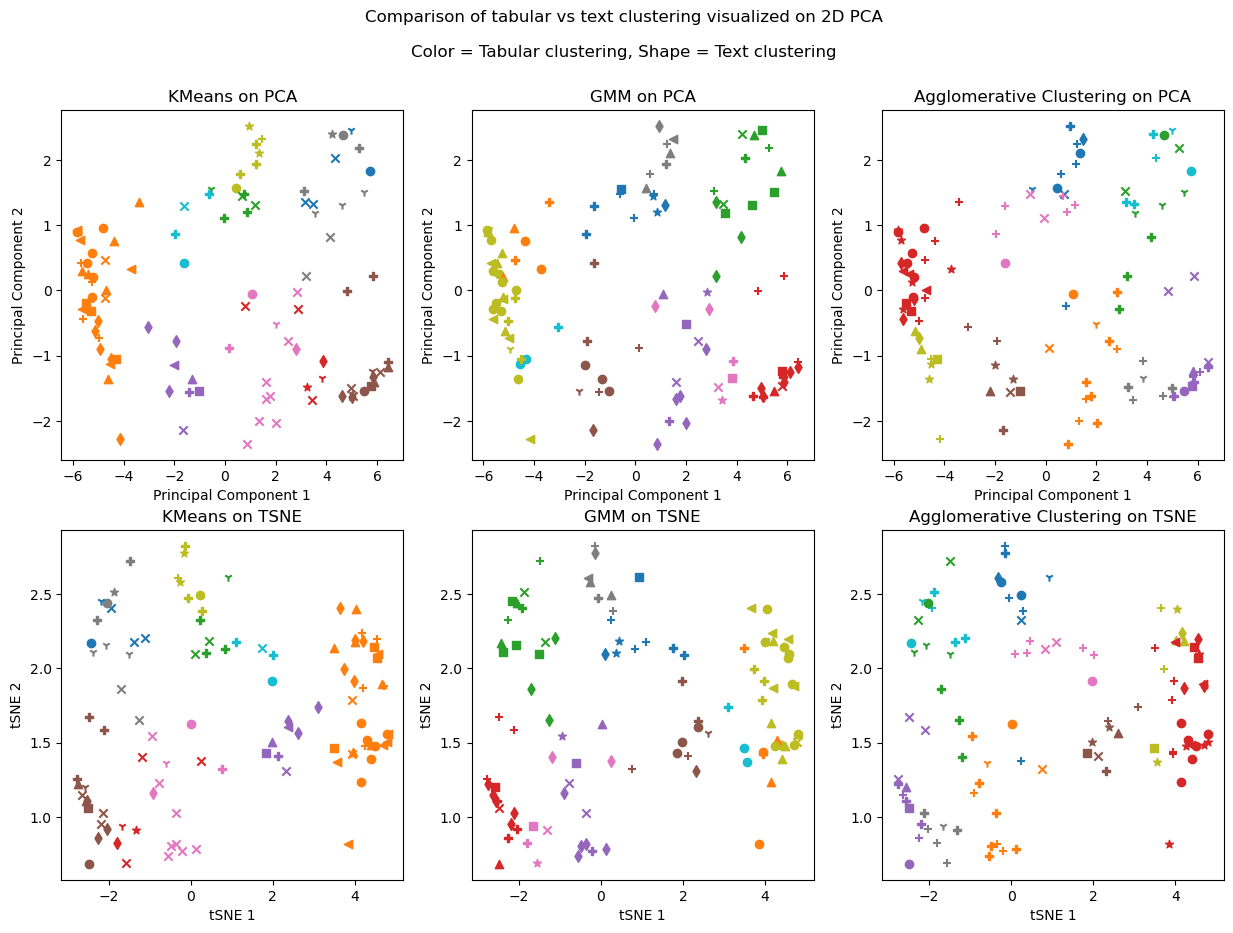

In [107]:
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors



fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i, clust_labels in enumerate([
  (labels_tab_km, labels_txt_km),
  (labels_tab_gm, labels_txt_gm),
  (labels_tab_agg, labels_txt_agg)
]):
  for j, dim_reducer in enumerate([
    PCA(n_components=2, random_state=1),
    TSNE(n_components=2, perplexity=50, random_state=1)
  ]):
    
    X_both_dimred = dim_reducer.fit_transform(X_both.todense())
    if j == 0 and i == 0:  # Best setting in our opinion
      labels_tab_best = clust_labels[0]
      labels_txt_best = clust_labels[1]
      X_both_best = X_both_dimred
    
    # map to colors
    colors = {i: c for i, c in enumerate(list(mcolors.TABLEAU_COLORS)[:10])}
    mapped_colors = []

    for label in clust_labels[0]:
      mapped_colors.append(colors[label])

    # map to markers
    markers = {0: "+", 1: "P", 2: "o", 3: "*",
              4: "x", 5: "^", 6: "s", 7: "d", 8: "1", 9: "<"}
    mapped_markers = []

    for label in clust_labels[1]:
      mapped_markers.append(markers[label])

    for _s, c, _x, _y in zip(mapped_markers, mapped_colors, X_both_dimred[:, 0], X_both_dimred[:, 1]):
      ax[j, i].scatter(_x, _y, marker=_s, c=c)
      
      title = f'{["KMeans", "GMM", "Agglomerative Clustering"][i]} on {dim_reducer.__class__.__name__}'
      ax[j, i].set_title(title)
      
      if j == 0:
        ax[j, i].set_xlabel("Principal Component 1")
        ax[j, i].set_ylabel("Principal Component 2")
      elif j == 1:
        ax[j, i].set_xlabel("tSNE 1")
        ax[j, i].set_ylabel("tSNE 2")

fig.suptitle("Comparison of tabular vs text clustering visualized on 2D PCA\n\nColor = Tabular clustering, Shape = Text clustering")
plt.show()

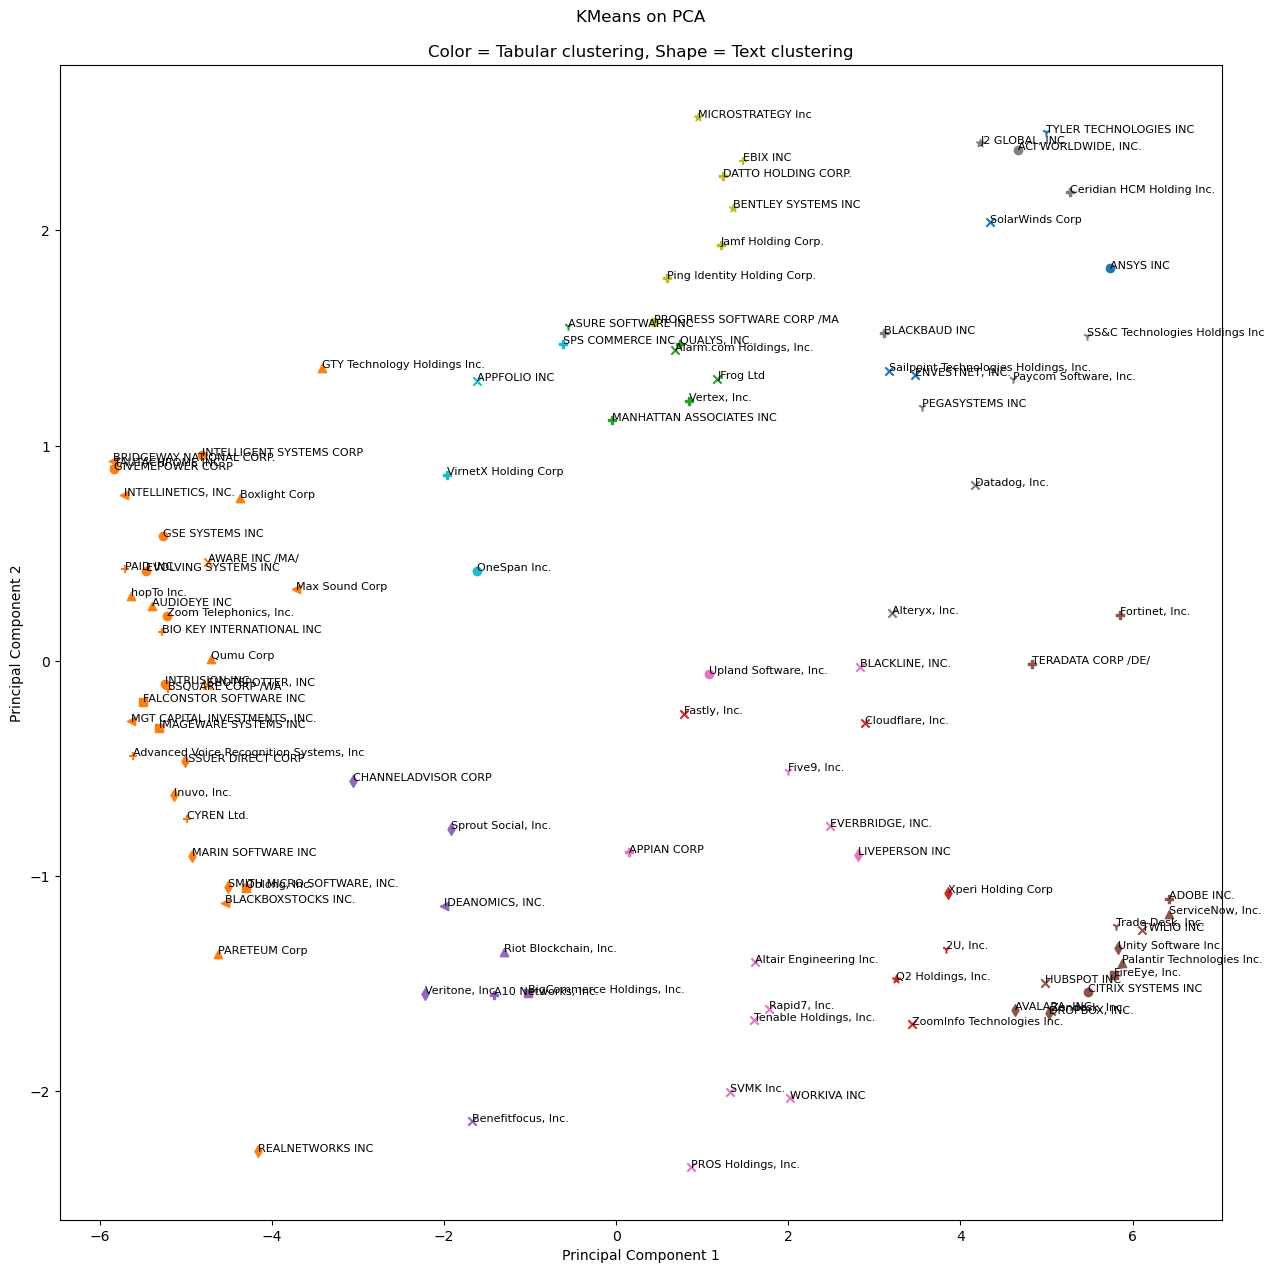

In [120]:
plt.figure(figsize=(15, 15))

# map to colors
colors = {i: c for i, c in enumerate(list(mcolors.TABLEAU_COLORS)[:10])}
mapped_colors = []

for label in labels_tab_best:
    mapped_colors.append(colors[label])

# map to markers
markers = {0: "+", 1: "P", 2: "o", 3: "*",
            4: "x", 5: "^", 6: "s", 7: "d", 8: "1", 9: "<"}
mapped_markers = []

for label in labels_txt_best:
    mapped_markers.append(markers[label])

for _s, c, _x, _y, i in zip(mapped_markers, mapped_colors, X_both_best[:, 0], X_both_best[:, 1], range(len(X_both_best))):
    plt.scatter(_x, _y, marker=_s, c=c)

    plt.title("KMeans on PCA\n\nColor = Tabular clustering, Shape = Text clustering")

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    
    # if np.random.rand() <= 0.1:
    plt.text(_x, _y, df_joined['company'][i], fontsize=8)

In [109]:
km_cluster_companies_text

defaultdict(list,
            {7: cik
             843006             ISSUER DIRECT CORP
             1615165                Veritone, Inc.
             948708     SMITH MICRO SOFTWARE, INC.
             1348036                 AVALARA, INC.
             1810806           Unity Software Inc.
             1389002            MARIN SOFTWARE INC
             1517375           Sprout Social, Inc.
             1046327              REALNETWORKS INC
             1467623                 DROPBOX, INC.
             829323                    Inuvo, Inc.
             1169652           CHANNELADVISOR CORP
             1803696            Xperi Holding Corp
             1102993                LIVEPERSON INC
             Name: company, dtype: object,
             9: cik
             1567771         BRIDGEWAY NATIONAL CORP.
             1001601    MGT CAPITAL INVESTMENTS, INC.
             1567900              BLACKBOXSTOCKS INC.
             1353499                   Max Sound Corp
             1081745

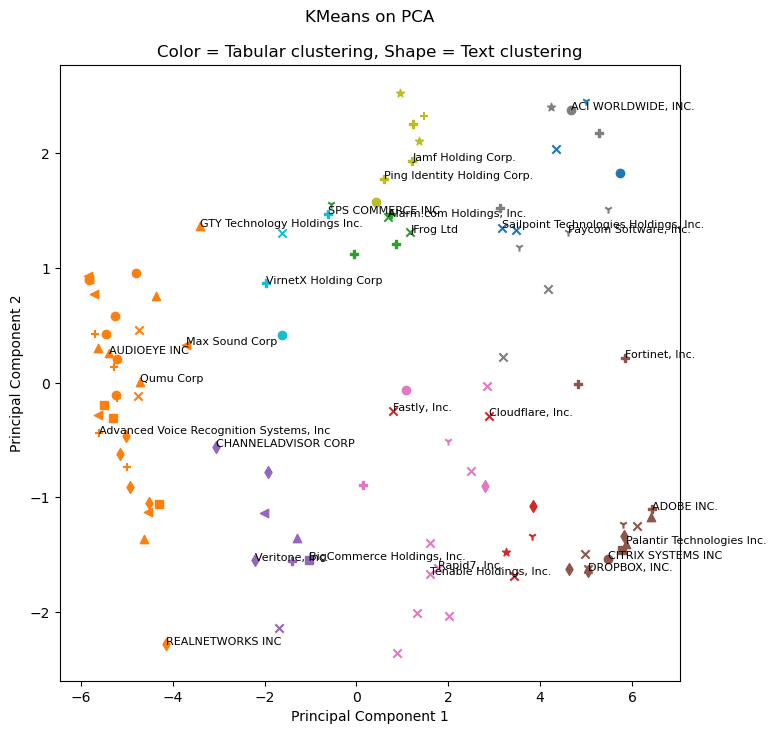

In [129]:
plt.figure(figsize=(8, 8))

# map to colors
colors = {i: c for i, c in enumerate(list(mcolors.TABLEAU_COLORS)[:10])}
mapped_colors = []

for label in labels_tab_best:
    mapped_colors.append(colors[label])

# map to markers
markers = {0: "+", 1: "P", 2: "o", 3: "*",
           4: "x", 5: "^", 6: "s", 7: "d", 8: "1", 9: "<"}
mapped_markers = []

for label in labels_txt_best:
    mapped_markers.append(markers[label])
    
HIGHLIGHTED_COMPANIES = [63, 55, 94, 78, 86, 83, 81, 100, 75, 40, 85, 27, 35, 61, 31, 13, 70, 96, 18, 43, 50, 46, 56, 30, 65, 97, 32]

for _s, c, _x, _y, i in zip(mapped_markers, mapped_colors, X_both_best[:, 0], X_both_best[:, 1], range(len(X_both_best))):
    plt.scatter(_x, _y, marker=_s, c=c)

    plt.title("KMeans on PCA\n\nColor = Tabular clustering, Shape = Text clustering")

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    if i in HIGHLIGHTED_COMPANIES:
        plt.text(_x, _y, df_joined['company'][i], fontsize=8)


In [124]:
# rapid7, tenable, qumu, maxsound, jfrog, alarm.com, channeladvisor, bigcommerce, jamf, ping, paycom, ACI worldwide, envestment, sailpoint, abobe, palantir, citrix, dropbox, advanced voice recognition systems, audioeye, sps commerce, virnetx, cloudflare, fastly

# 

list(enumerate(df_joined['company']))

[(0, 'ISSUER DIRECT CORP'),
 (1, 'BRIDGEWAY NATIONAL CORP.'),
 (2, 'MICROSTRATEGY Inc'),
 (3, 'Five9, Inc.'),
 (4, 'Riot Blockchain, Inc.'),
 (5, 'BENTLEY SYSTEMS INC'),
 (6, 'APPFOLIO INC'),
 (7, 'BSQUARE CORP /WA'),
 (8, 'Upland Software, Inc.'),
 (9, 'WORKIVA INC'),
 (10, 'SS&C Technologies Holdings Inc'),
 (11, 'ZoomInfo Technologies Inc.'),
 (12, 'SolarWinds Corp'),
 (13, 'CITRIX SYSTEMS INC'),
 (14, 'PROS Holdings, Inc.'),
 (15, 'EVOLVING SYSTEMS INC'),
 (16, 'PEGASYSTEMS INC'),
 (17, 'Datadog, Inc.'),
 (18, 'AUDIOEYE INC'),
 (19, 'APPIAN CORP'),
 (20, 'Oblong, Inc.'),
 (21, 'GSE SYSTEMS INC'),
 (22, 'ASURE SOFTWARE INC'),
 (23, 'PROGRESS SOFTWARE CORP /MA'),
 (24, 'EBIX INC'),
 (25, 'TWILIO INC'),
 (26, 'GIVEMEPOWER CORP'),
 (27, 'ACI WORLDWIDE, INC.'),
 (28, 'MGT CAPITAL INVESTMENTS, INC.'),
 (29, 'INTRUSION INC'),
 (30, 'GTY Technology Holdings Inc.'),
 (31, 'Palantir Technologies Inc.'),
 (32, 'Veritone, Inc.'),
 (33, 'QUALYS, INC.'),
 (34, 'BLACKBOXSTOCKS INC.'),
 (35, 'Sail